<h1 style = "color: skyblue; font-family: Arial; font-size: 40 px; text-align: center;">Short-Term Bitcoin Price Prediction Using LSTM Networks</h1>

<img src="bitcoin.jpeg" alt="Bitcoin Image" style="width:1180px; height:auto;">

#### **Problem Statement**:
The cryptocurrency market, particularly Bitcoin, is characterized by extreme volatility and rapid price changes. Accurately predicting short-term price movements of Bitcoin can provide substantial advantages for traders and investors, enabling more informed decision-making and potential profit maximization. However, the inherent volatility and the influence of various external factors make this prediction task highly challenging. This project aims to address this challenge by developing a model using Long Short-Term Memory (LSTM) networks, a type of Recurrent Neural Network (RNN), to predict short-term price movements of Bitcoin using historical price data obtained from Yahoo Finance.


#### **Objective**:
The objective of this project is to leverage LSTM networks to predict short-term price movements of Bitcoin based on historical data from Yahoo Finance.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

import yfinance as yf
import pandas_ta as ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from datetime import datetime


<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px">Data Collection</h2>

In [2]:
# fetch data
ticker = 'BTC-USD'
start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
data = yf.download(ticker, start_date, end_date)
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095


In [3]:
# Data of the data
data.shape

(1647, 6)

In [4]:
# Check for missing values
data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


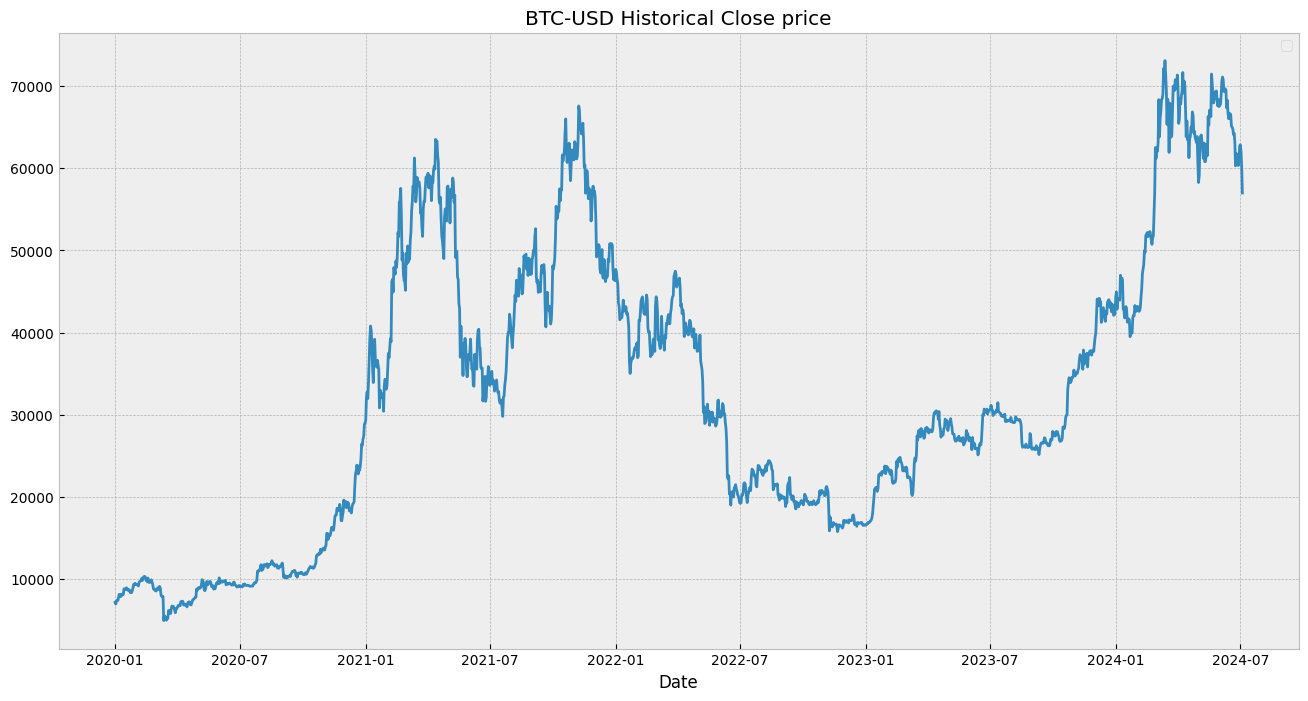

In [5]:
# Visualize the data
plt.figure(figsize=(16,8))
plt.title(f'{ticker} Historical Close price')
plt.xlabel('Close price USD ($)')
plt.xlabel('Date')
plt.plot(data['Close'])
plt.legend()
plt.show()

<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px;">Feature Engineering</h2>

In [6]:
# Add technical indicators
data['RSI'] = ta.rsi(data['Close'], length=15)
data['EMA20'] = ta.ema(data['Close'], length=20)
data['EMA100'] = ta.ema(data['Close'], length=100)
data['EMA150'] = ta.ema(data['Close'], length=150)

#data['TargetNextClose'] = data['Adj Close'].shift(-1)

# Drop rows with NaN values created by the indicators
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume','Date'], axis=1, inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,RSI,EMA20,EMA100,EMA150
0,9528.355469,9573.666992,9379.338867,9439.124023,9439.124023,56.951931,9155.102804,8486.873028,8247.269193
1,9438.914062,9704.030273,9366.729492,9700.414062,9700.414062,60.237587,9207.037209,8510.903544,8266.516145
2,9700.105469,9700.343750,9432.296875,9461.058594,9461.058594,56.039546,9231.229722,8529.718495,8282.337899
3,9463.605469,10199.565430,9450.899414,10167.268555,10167.268555,63.975974,9320.376278,8562.145229,8307.303868
4,10162.973633,10182.340820,9460.571289,9529.803711,9529.803711,54.466099,9340.321747,8581.306783,8323.495919


<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px;">Normalize and Split the Data</h2>

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)


[[7.49473185e-03 6.37090667e-03 6.47566946e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.09788460e-03 8.38929259e-03 6.27346188e-03 ... 8.71373974e-04
  4.30571999e-04 3.63790355e-04]
 [1.01770300e-02 8.33221496e-03 7.32491936e-03 ... 1.27728458e-03
  7.67692993e-04 6.62840389e-04]
 ...
 [8.40155884e-01 8.36707601e-01 8.46350744e-01 ... 9.11301414e-01
  9.91350854e-01 1.00000000e+00]
 [8.27504524e-01 8.20982420e-01 8.08932319e-01 ... 9.06035750e-01
  9.90059035e-01 9.99754645e-01]
 [7.98031334e-01 7.93298787e-01 7.66571147e-01 ... 8.96164215e-01
  9.87658757e-01 9.98712376e-01]]


In [8]:
# Create sequences
def create_sequences(data, time_step=1):
    
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i + time_step),:])
        y.append(data[i + time_step, 3])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_data, time_step)

# Reshape input to be [samples, time steps, features]
X = X.reshape(X.shape[0], time_step, X.shape[2])


print(X.shape)
print(X)

(1437, 60, 9)
[[[7.49473185e-03 6.37090667e-03 6.47566946e-03 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [6.09788460e-03 8.38929259e-03 6.27346188e-03 ... 8.71373974e-04
   4.30571999e-04 3.63790355e-04]
  [1.01770300e-02 8.33221496e-03 7.32491936e-03 ... 1.27728458e-03
   7.67692993e-04 6.62840389e-04]
  ...
  [7.66855231e-03 8.39744222e-03 8.89511318e-03 ... 3.28611686e-03
   1.06703165e-02 1.13281336e-02]
  [9.86669403e-03 1.33403347e-02 1.08617353e-02 ... 4.17170995e-03
   1.09622427e-02 1.15931417e-02]
  [1.33803624e-02 3.30718064e-02 1.48888013e-02 ... 6.70785259e-03
   1.16336035e-02 1.21264430e-02]]

 [[6.09788460e-03 8.38929259e-03 6.27346188e-03 ... 8.71373974e-04
   4.30571999e-04 3.63790355e-04]
  [1.01770300e-02 8.33221496e-03 7.32491936e-03 ... 1.27728458e-03
   7.67692993e-04 6.62840389e-04]
  [6.48350156e-03 1.60615541e-02 7.62323504e-03 ... 2.77301727e-03
   1.34870606e-03 1.13472699e-03]
  ...
  [9.86669403e-03 1.33403347e-02 1.08617353e-02 ... 4.17170995e

In [9]:
# split into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

<h2 style = "color: skyblue; font-family: Arial; font-size: 30 px;">Build LSTM Networks and Make Predictions</h2>

In [10]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(150, input_shape=(time_step, X.shape[2])))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=15, verbose=2)


C:\Users\Nkamanyi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
77/77 - 7s - 89ms/step - loss: 0.0068
Epoch 2/30
77/77 - 3s - 35ms/step - loss: 9.6525e-04
Epoch 3/30
77/77 - 3s - 38ms/step - loss: 8.5055e-04
Epoch 4/30
77/77 - 3s - 34ms/step - loss: 7.8726e-04
Epoch 5/30
77/77 - 3s - 38ms/step - loss: 6.8880e-04
Epoch 6/30
77/77 - 3s - 37ms/step - loss: 7.8306e-04
Epoch 7/30
77/77 - 3s - 40ms/step - loss: 6.4546e-04
Epoch 8/30
77/77 - 3s - 39ms/step - loss: 6.0688e-04
Epoch 9/30
77/77 - 3s - 38ms/step - loss: 5.3715e-04
Epoch 10/30
77/77 - 3s - 43ms/step - loss: 5.8484e-04
Epoch 11/30
77/77 - 3s - 45ms/step - loss: 5.4132e-04
Epoch 12/30
77/77 - 4s - 51ms/step - loss: 6.1118e-04
Epoch 13/30
77/77 - 4s - 50ms/step - loss: 5.5591e-04
Epoch 14/30
77/77 - 4s - 49ms/step - loss: 5.3588e-04
Epoch 15/30
77/77 - 4s - 50ms/step - loss: 5.6291e-04
Epoch 16/30
77/77 - 4s - 49ms/step - loss: 5.1457e-04
Epoch 17/30
77/77 - 4s - 46ms/step - loss: 5.0178e-04
Epoch 18/30
77/77 - 3s - 43ms/step - loss: 5.4332e-04
Epoch 19/30
77/77 - 3s - 43ms/step - loss

In [11]:
# make predictions
train_Pred = model.predict(X_train)
test_Pred = model.predict(X_test)

# invert predictions
#train_Pred = scaler.inverse_transform(train_Pred)
#y_train = scaler.inverse_transform([y_train])
#test_Pred = scaler.inverse_transform(test_Pred)
#y_test = scaler.inverse_transform([y_test])


train_Pred = scaler.inverse_transform(np.concatenate((train_Pred, np.zeros((train_Pred.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]
y_train = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]
test_Pred = scaler.inverse_transform(np.concatenate((test_Pred, np.zeros((test_Pred.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(y_train, train_Pred))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test, test_Pred))
print('Test Score: %.2f RMSE' % (testScore))


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Train Score: 1335.99 RMSE
Test Score: 1540.98 RMSE


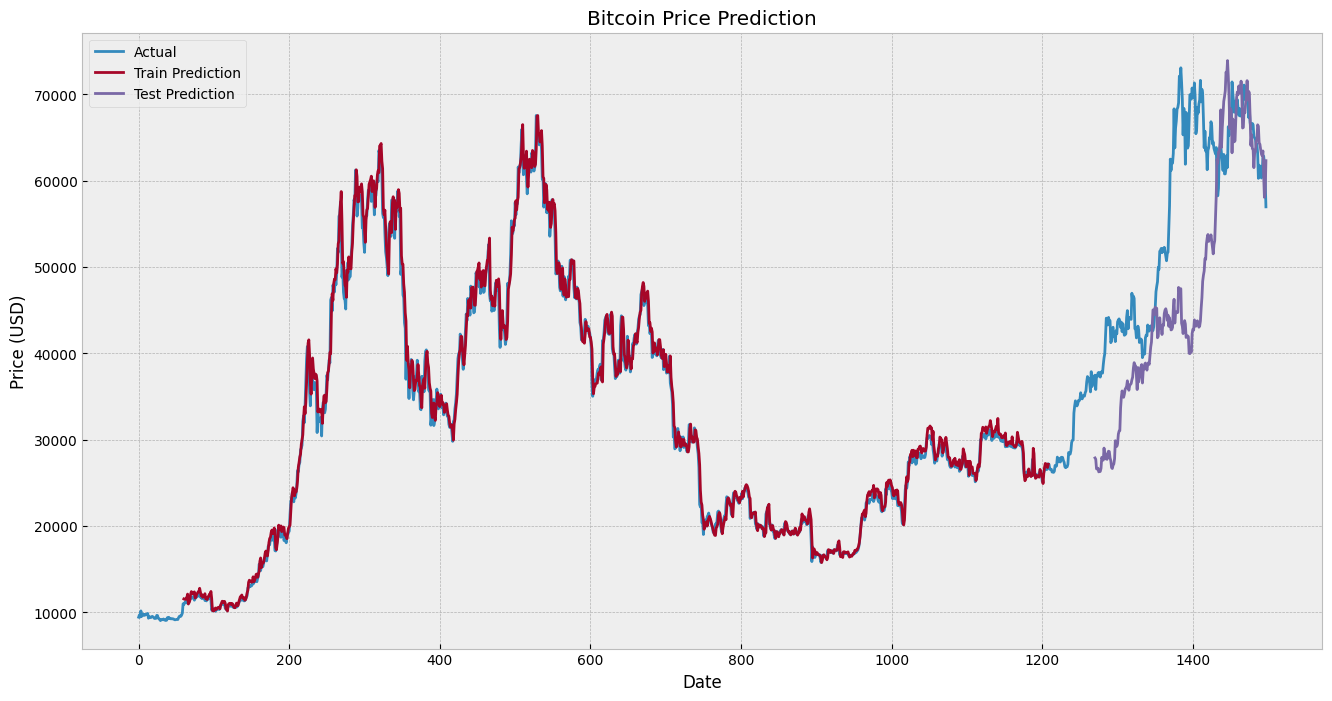

In [12]:
# Ensure test predictions fit within the allocated space
train_size = len(train_Pred)
test_start_index = train_size + (time_step * 2) + 1
test_end_index = test_start_index + len(test_Pred)

# Adjust if test_end_index goes beyond the length of testPredictPlot
if test_end_index > len(scaled_data):
    test_end_index = len(scaled_data)
    test_Pred = test_Pred[:test_end_index - test_start_index]

# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_step:train_size + time_step, 0] = train_Pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[test_start_index:test_end_index, 0] = test_Pred

# plot baseline and predictions
plt.figure(figsize=(16,8))
plt.plot(scaler.inverse_transform(scaled_data)[:, data.columns.get_loc('Close')])
plt.plot(trainPredictPlot[:, 0])
plt.plot(testPredictPlot[:, 0])
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(['Actual', 'Train Prediction', 'Test Prediction'])
plt.show()
